**Problem Definition:**
Build a multiclass clasifier which accurately classify the input images into the 6 classes.

**Data Categories:**
* Building
* Forest
* Glacier
* Mountain
* Sea
* Street

Image Dimention: 150 x 150
Dataset size: 24k -  Train:14k, Test:3k

[Dataset link](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data)

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

2025-09-03 08:06:56.558358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756886816.903056      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756886817.007353      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
#numeric label
class_label_numeric = {class_label:i for i, class_label in enumerate(class_labels)}
class_label_numeric

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [3]:
# Data block
img_size = (150, 150)
dataset_train = '/kaggle/input/intel-image-classification/seg_train/seg_train'
dataset_test = '/kaggle/input/intel-image-classification/seg_test/seg_test'

def data_loader(dataset):
    
    Images = []
    Labels = []

    for folder in os.listdir(dataset):
        for img in tqdm(os.listdir(os.path.join(dataset,folder))):
            
            image_path = os.path.join(os.path.join(dataset,folder),img)  

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , img_size)

            Images.append(image)
            Labels.append(class_label_numeric[folder])
            
    Images = np.array(Images , dtype='float32')
    Labels = np.array(Labels , dtype='int32')

    return (Images , Labels)  


In [4]:
(train_image , train_label) = data_loader(dataset_train)
(test_image, test_label) = data_loader(dataset_test)

train_image , train_label = shuffle(train_image , train_label , random_state= 25)

train_image = train_image / 255.0
test_image = test_image / 255.0

100%|██████████| 553/553 [00:05<00:00, 106.63it/s]


**Data Insights**

In [5]:
print(f"Training count {train_label.shape[0]}")
print(f"Testing count {test_label.shape[0]}")

Training count 14034
Testing count 3000


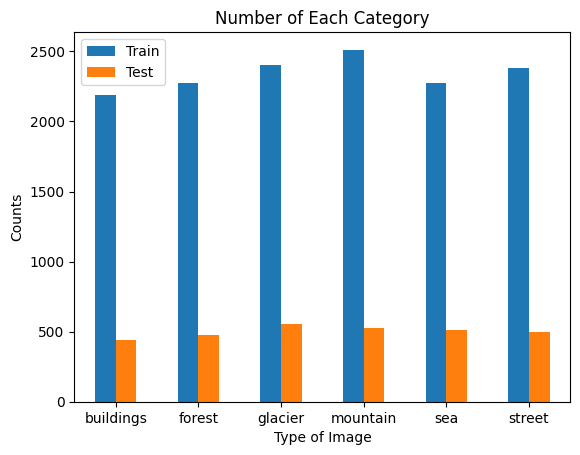

In [6]:
_ , train_counts = np.unique(train_label , return_counts = True)
_ , test_counts = np.unique(test_label , return_counts = True)

df = pd.DataFrame({'Train':train_counts,
              'Test':test_counts},index = class_labels)

df.plot.bar()
plt.xticks(rotation = 0)
plt.title('Number of Each Category')
plt.ylabel('Counts')
plt.xlabel('Type of Image')
plt.show()

In [7]:
df

,Train,Test
buildings,2191,437
forest,2271,474
glacier,2404,553
mountain,2512,525
sea,2274,510
street,2382,501


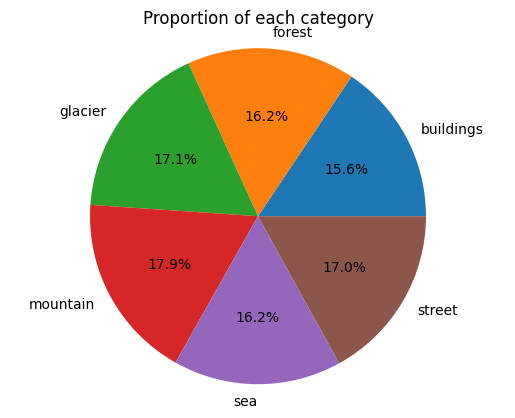

In [8]:
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0), labels=class_labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each category')
plt.show()

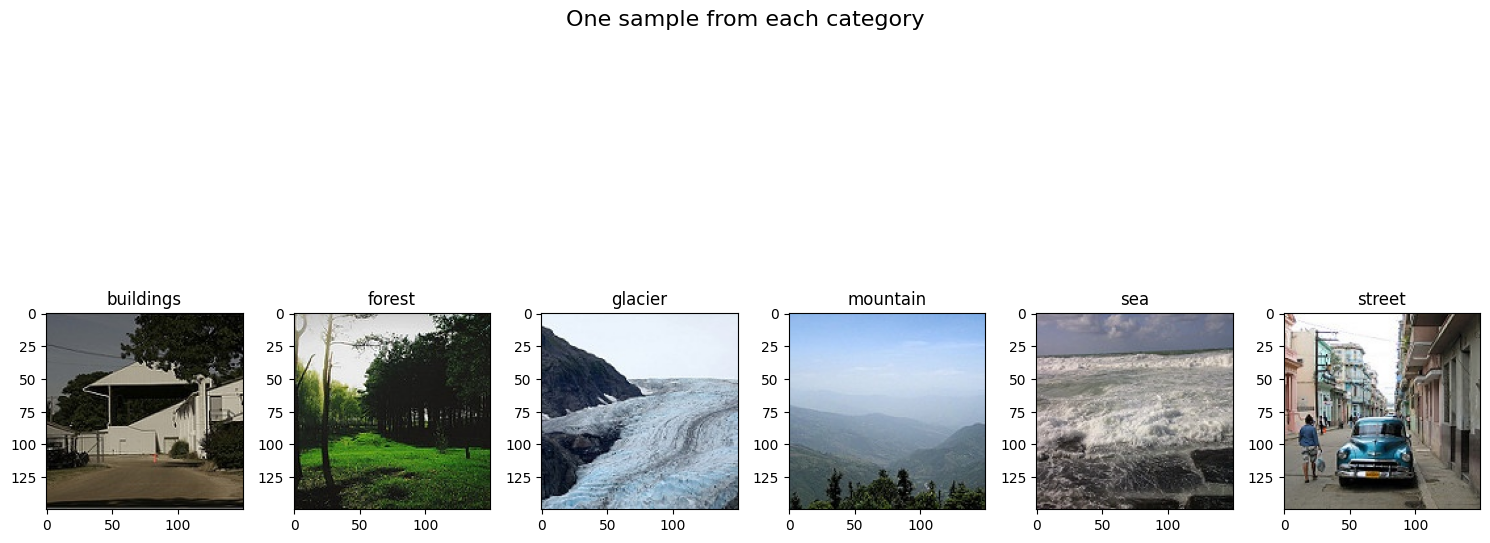

In [9]:
plt.figure(figsize=(15, 8))
plt.suptitle("One sample from each category", fontsize=16)

num_classes = len(class_labels) 

for i, class_id in enumerate(range(num_classes)):
    plt.subplot(1, num_classes, i+1)

    # Find all indices for this class
    Category_list = np.where(train_label == class_id)[0]

    # Pick one random index
    idx = np.random.choice(Category_list)

    # Show the image
    plt.imshow(train_image[idx])
    plt.title(class_labels[class_id])


plt.tight_layout()
plt.show()

**Model**

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 3)),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),


    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

model.summary()

I0000 00:00:1756887024.268232      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756887024.269340      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,330,502 (81.37 MB)

 Trainable params: 21,330,502 (81.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_image, train_label, batch_size=200, epochs=30, validation_split = 0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/30


I0000 00:00:1756887036.121151      68 service.cc:148] XLA service 0x79b474002c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756887036.122565      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756887036.122602      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756887036.500279      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/57 ━━━━━━━━━━━━━━━━━━━━ 13:51 15s/step - accuracy: 0.1900 - loss: 1.7896

I0000 00:00:1756887048.553913      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 308ms/step - accuracy: 0.3761 - loss: 1.7033 - val_accuracy: 0.6010 - val_loss: 0.9725
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6460 - loss: 0.9104 - val_accuracy: 0.6958 - val_loss: 0.8042
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.7170 - loss: 0.7650 - val_accuracy: 0.7357 - val_loss: 0.6987
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.7755 - loss: 0.6085 - val_accuracy: 0.7802 - val_loss: 0.5876
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8181 - loss: 0.5210 - val_accuracy: 0.8115 - val_loss: 0.5218
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8332 - loss: 0.4692 - val_accuracy: 0.7659 - val_loss: 0.6547
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.8477 - loss: 0.4284 - val_accuracy: 0.8080 - val_loss: 0.5564
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8817 - loss: 0.3414 - val_accuracy: 0.8226 - va

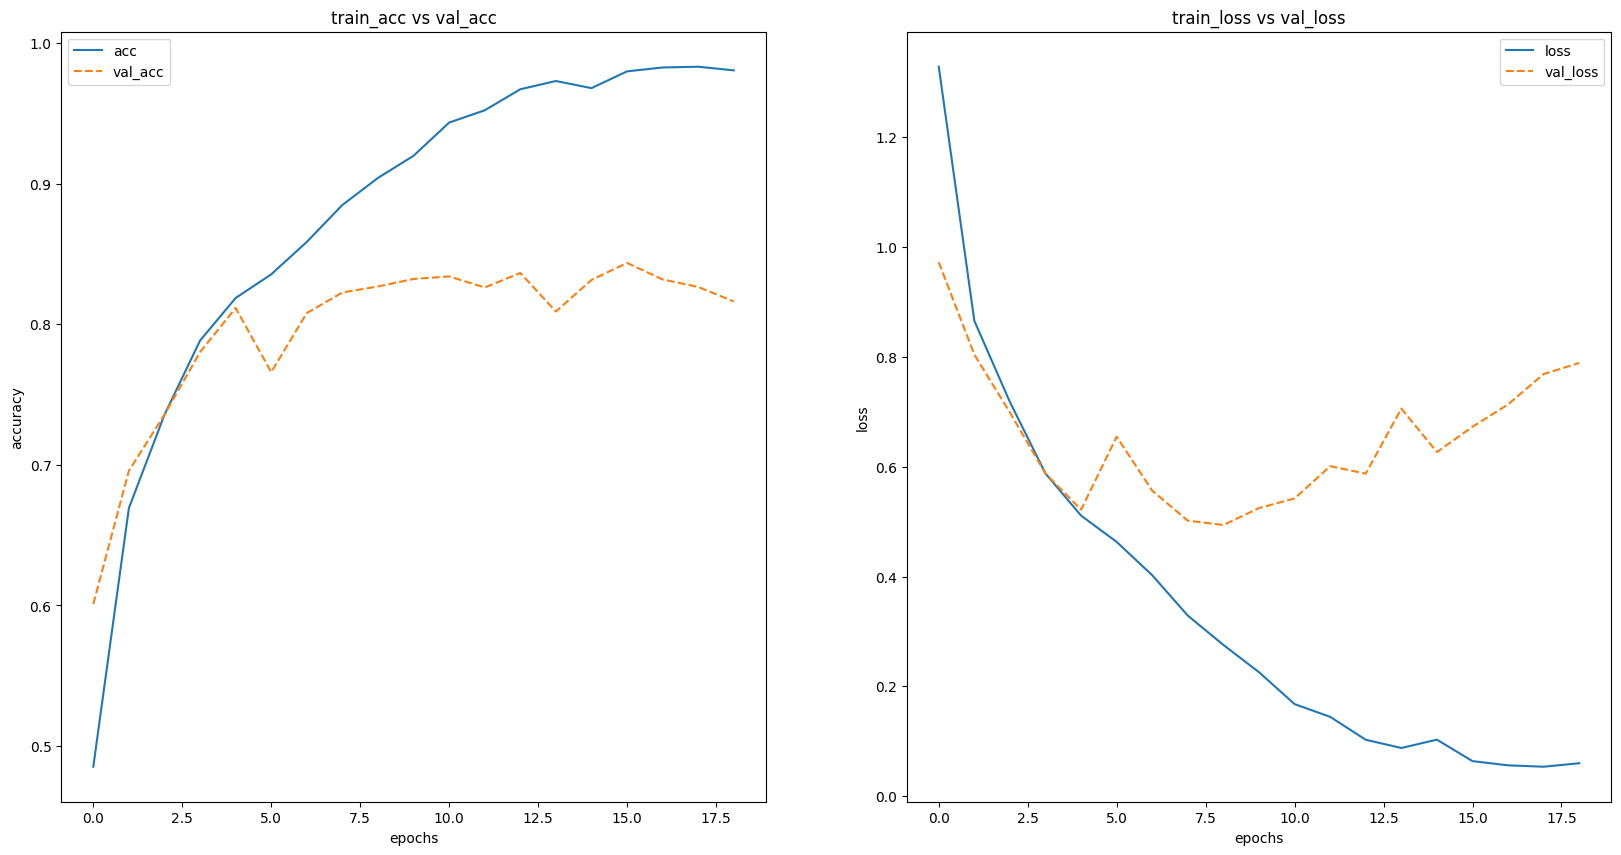

In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history)  

In [14]:
model.evaluate(test_image,test_label)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8119 - loss: 0.5683


[0.53960120677948, 0.8259999752044678]

In [15]:
predictions = model.predict(test_image)     
pred_labels = np.argmax(predictions, axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


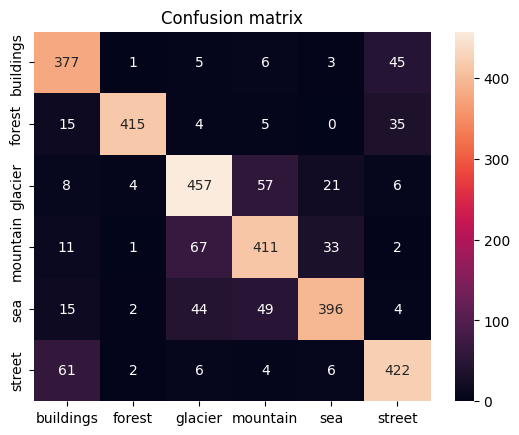

In [16]:
CM = confusion_matrix(test_label, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels = class_labels, 
           yticklabels = class_labels,
           ax = ax,
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()